In [1]:
# training
# A neural network implemented in PyTorch.
# At least one other Scikit-learn algorithm (for example, K-NN, SVM, Random Forest, Logistic Regression, etc.).
import pandas as pd
import numpy as np
from sklearn import neighbors

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

In [2]:
# traindata = pd.read_csv('Datasets/PractiseData/development.csv', header=0)
traindata = pd.read_csv('Datasets/EvaluationData/politicES_phase_2_train_public.csv', header=0)

ytrain = traindata.iloc[:, :]
# print(ytrain)

## Exploratory Analysis of the Dataset

Before applying language processing techniques, a exploratory analysis of the dataset is performed. This analysis includes:
- General description: Number of instances, variables, data types, missing values
- Basic statistics and simple visualizations (class distribution, text lengths, etc.)
- Preliminary text analysis (most frequent words, word cloud, examples by class)
- Formulation of initial hypoteses about possible relationships between disinfomation and polarization.

### General description

In [3]:
# Shape of the training data
print("Training data shape:", ytrain.shape)

# Print the headers of the dataset
print("Headers:", ytrain.columns.tolist())

# Print the data types of each column
for col in ytrain.columns:
    first_non_null = ytrain[col].dropna().iloc[0] if not ytrain[col].dropna().empty else None
    padding = ' ' * (max(len(c) for c in ytrain.columns) - len(col))
    print(f"  Column '{col}' {padding} -> type: {type(first_non_null).__name__}")

# Users are in the first column, extract unique users from ytrain
unique_users = ytrain.iloc[:, 0].unique()
print("Unique users (labels) in training data:", len(unique_users))


Training data shape: (180000, 6)
Headers: ['label', 'gender', 'profession', 'ideology_binary', 'ideology_multiclass', 'tweet']
  Column 'label'                -> type: str
  Column 'gender'               -> type: str
  Column 'profession'           -> type: str
  Column 'ideology_binary'      -> type: str
  Column 'ideology_multiclass'  -> type: str
  Column 'tweet'                -> type: str
Unique users (labels) in training data: 2250


### Statics and simple visualizations

In [4]:
# Compute class distribution
class_counts = ytrain.iloc[:, 0].value_counts()
class_counts_unique = class_counts.nunique()

if class_counts_unique == 1:
    print("All classes have the same number of samples.")
    print(f"Each class has {class_counts.iloc[0]} samples.")
else:
    print("Class distribution in training data:")
    # Group consecutive classes with same count
    prev_count = None
    start_cls = None
    
    for cls, count in class_counts.items():
        if count != prev_count:
            if prev_count is not None:
                if start_cls == prev_cls:
                    print(f"  Classes {start_cls}: {prev_count} samples")
                else:
                    print(f"  Classes {start_cls} to {prev_cls}: {prev_count} samples")
            start_cls = cls
            prev_count = count
        prev_cls = cls
    
    # Print the last group
    if start_cls == prev_cls:
        print(f"  Classes {start_cls}: {prev_count} samples")
    else:
        print(f"  Classes {start_cls} to {prev_cls}: {prev_count} samples")

print(f"{'-' * 35}")

# Print text length statistics (from tweets column, which corresponds to the last column)
text_lengths = ytrain.iloc[:, -1].dropna().apply(len)
print("Text length statistics:")
print(f"  Minimum length: {text_lengths.min()}")
print(f"  Maximum length: {text_lengths.max()}")
print(f"  Average length: {text_lengths.mean():.2f}")
print(f"  Median length: {text_lengths.median()}")

All classes have the same number of samples.
Each class has 80 samples.
-----------------------------------
Text length statistics:
  Minimum length: 17
  Maximum length: 511
  Average length: 167.98
  Median length: 163.0


### Preliminary text analysis

Most common words in tweets:
  'de': 290977 occurrences
  'la': 195399 occurrences
  'que': 156810 occurrences
  'y': 140648 occurrences
  'el': 140596 occurrences
  'en': 133278 occurrences
  'a': 123696 occurrences
  '@user': 96574 occurrences
  'los': 75447 occurrences
  'no': 62067 occurrences
Most common words in tweets (cleaned):
  'gobierno': 10170 occurrences
  'gracias': 6561 occurrences
  'españa': 6515 occurrences
  'años': 6351 occurrences
  'ley': 5457 occurrences
  'solo': 5272 occurrences
  'día': 5138 occurrences
  'dos': 4930 occurrences
  'ahora': 4860 occurrences
  'puede': 4829 occurrences


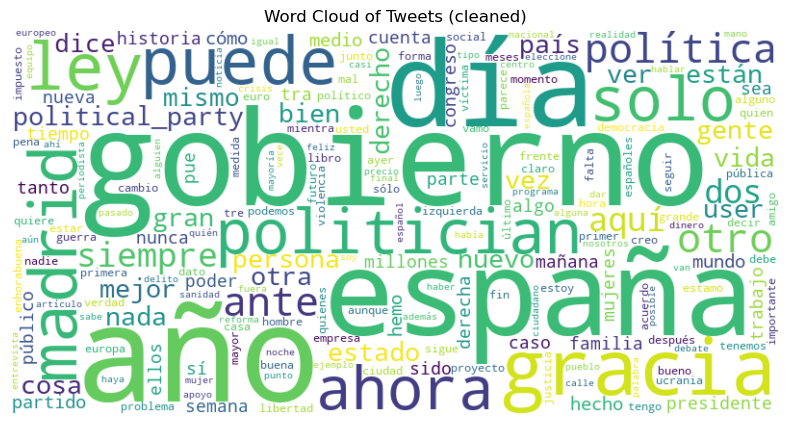

In [5]:
# Print most frequent words in the tweets, word cloud and examples by class
all_text = ' '.join(ytrain.iloc[:, -1].dropna().astype(str).tolist())
words = all_text.lower().split()

word_counts = Counter(words)
most_common_words = word_counts.most_common(10)
print("Most common words in tweets:")
for word, count in most_common_words:
    print(f"  '{word}': {count} occurrences")

# Remove very short tokens and common noise
stopwords = {
    'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'se', 'del', 'las', 'un',
    'por', 'con', 'no', 'una', 'su', 'para', 'es', 'al', 'lo', 'como', 'más',
    'o', 'pero', 'sus', 'le', 'ya', 'o', 'si', 'sobre', 'este', 'también',
    'me', 'hasta', 'hay', 'donde', 'han', 'tu', 'te', 'rt', 'https', '[hashtag]',
    '[politician]', '[political_party]', 'esta', 'está', 'qué', 'hoy', 'nos', 
    'todo', 'son', 'muy', 'sin', 'desde', 'cuando', 'todo', 'todos', 'toda',
    'todas', 'uno', 'una', 'unos', 'unas', 'ser', 'fue', 'fueron', 'será', 
    'serán', 'tener', 'tiene', 'tienen', 'hacer', 'hace', 'hacen', 'porque', 
    'eso', 'esto', 'ese', 'esa', 'esos', 'esas', 'mi', 'mis', 'tu', 'tus',
    'su', 'sus', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'les', 'ello',
    'tan', 'sino', 'estos', 'estas', 'durante', 'contra', 'entre', 'así', 'más',
    'menos', 'cada', 'poco', 'muy', 'mucho', 'muchos', 'muchas', 'ella', 'era'
}

clean_words = [
    w for w in words
    if len(w) > 2
    and not w.startswith('@')    # remove mentions
    and not w.startswith('http') # remove URLs
    and w not in stopwords
]

word_counts = Counter(clean_words)
most_common_words = word_counts.most_common(10)

print("Most common words in tweets (cleaned):")
for word, count in most_common_words:
    print(f"  '{word}': {count} occurrences")



wc_stopwords = STOPWORDS.union(stopwords).union({'https', 'rt'})
clean_text = ' '.join(clean_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=wc_stopwords,
    collocations=False  # avoid duplicated bigrams like "new york"
).generate(clean_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets (cleaned)')
plt.show()

### Preliminary hypotheses

Although one might initially assume that disinformation mainly originates from more extreme or non‑moderate individuals, our analysis will explore whether this intuition is actually supported by the data.